In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 

import warnings
warnings.filterwarnings("ignore")

import calendar


# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from scipy import stats


from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


pd.options.display.float_format = "{:,.2f}".format 

# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations


from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder#, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

sys.path.append(os.path.abspath("../../src"))   
import soporte_preprocesamiento as f
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder     #solo me deja hacerlo si uso el entorno default en vez del proyecto
pd.set_option("display.max_columns", None)


In [2]:
df_sinout=pd.read_csv("../../datos/datos1/datos_sin_outliers_iterativo.csv", index_col=0).reset_index(drop=True)


In [3]:
df_sinout["rooms"]=df_sinout["rooms"].astype("O")
df_sinout["bathrooms"]=df_sinout["bathrooms"].astype("O")
df_sinout["exterior"]=df_sinout["exterior"].astype("O")

In [4]:
df_sinout.head(2)

,price,propertyType,exterior,rooms,bathrooms,province,municipality,status,newDevelopment,floor,district,hasLift,parkingSpace,size_MinMax,distance_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,750.00,flat,True,1,1,Madrid,Madrid,good,False,3,Hortaleza,True,desconocido,0.31,0.11,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,750.00,flat,True,2,1,Madrid,San Sebastián de los Reyes,good,False,bj,Centro Urbano,False,desconocido,0.39,0.27,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [5]:
df_sinout.duplicated().sum()

np.int64(0)

In [6]:
df_sinout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   424 non-null    float64
 1   propertyType            424 non-null    object 
 2   exterior                424 non-null    object 
 3   rooms                   424 non-null    object 
 4   bathrooms               424 non-null    object 
 5   province                424 non-null    object 
 6   municipality            424 non-null    object 
 7   status                  424 non-null    object 
 8   newDevelopment          424 non-null    object 
 9   floor                   424 non-null    object 
 10  district                424 non-null    object 
 11  hasLift                 424 non-null    object 
 12  parkingSpace            424 non-null    object 
 13  size_MinMax             424 non-null    float64
 14  distance_MinMax         424 non-null    fl

In [7]:
df_sinout_copy=df_sinout.copy()

Se ha comprobado usando value_counts que las columnas con las que contamos tiene sentido mantenerlas pues no domina una categoría frente a la otra de manera exagerada (Es decir que no nos vaya a aportar información relevante)

In [8]:
df_sinout_copy["parkingSpace"].value_counts()

parkingSpace
desconocido    299
True           121
False            4
Name: count, dtype: int64

In [9]:
# df_sinout_copy["municipality"].value_counts()

In [10]:
df_categoricas= df_sinout_copy.select_dtypes("O")

Tenemos 12 columnas de categóricas

In [11]:
df_categoricas.nunique()

propertyType       6
exterior           2
rooms              5
bathrooms          3
province           2
municipality      89
status             4
newDevelopment     3
floor             14
district          96
hasLift            3
parkingSpace       3
dtype: int64

In [12]:
df_categoricas.head()

,propertyType,exterior,rooms,bathrooms,province,municipality,status,newDevelopment,floor,district,hasLift,parkingSpace
0,flat,True,1,1,Madrid,Madrid,good,False,3,Hortaleza,True,desconocido
1,flat,True,2,1,Madrid,San Sebastián de los Reyes,good,False,bj,Centro Urbano,False,desconocido
2,penthouse,True,2,2,Madrid,Villamanrique de Tajo,good,False,2,desconocido,False,desconocido
3,flat,False,2,1,Afueras,Recas,good,False,2,desconocido,True,True
4,flat,True,2,1,Afueras,Cedillo del Condado,good,False,1,desconocido,False,desconocido


Vamos a recordar la distribución de la categóricas

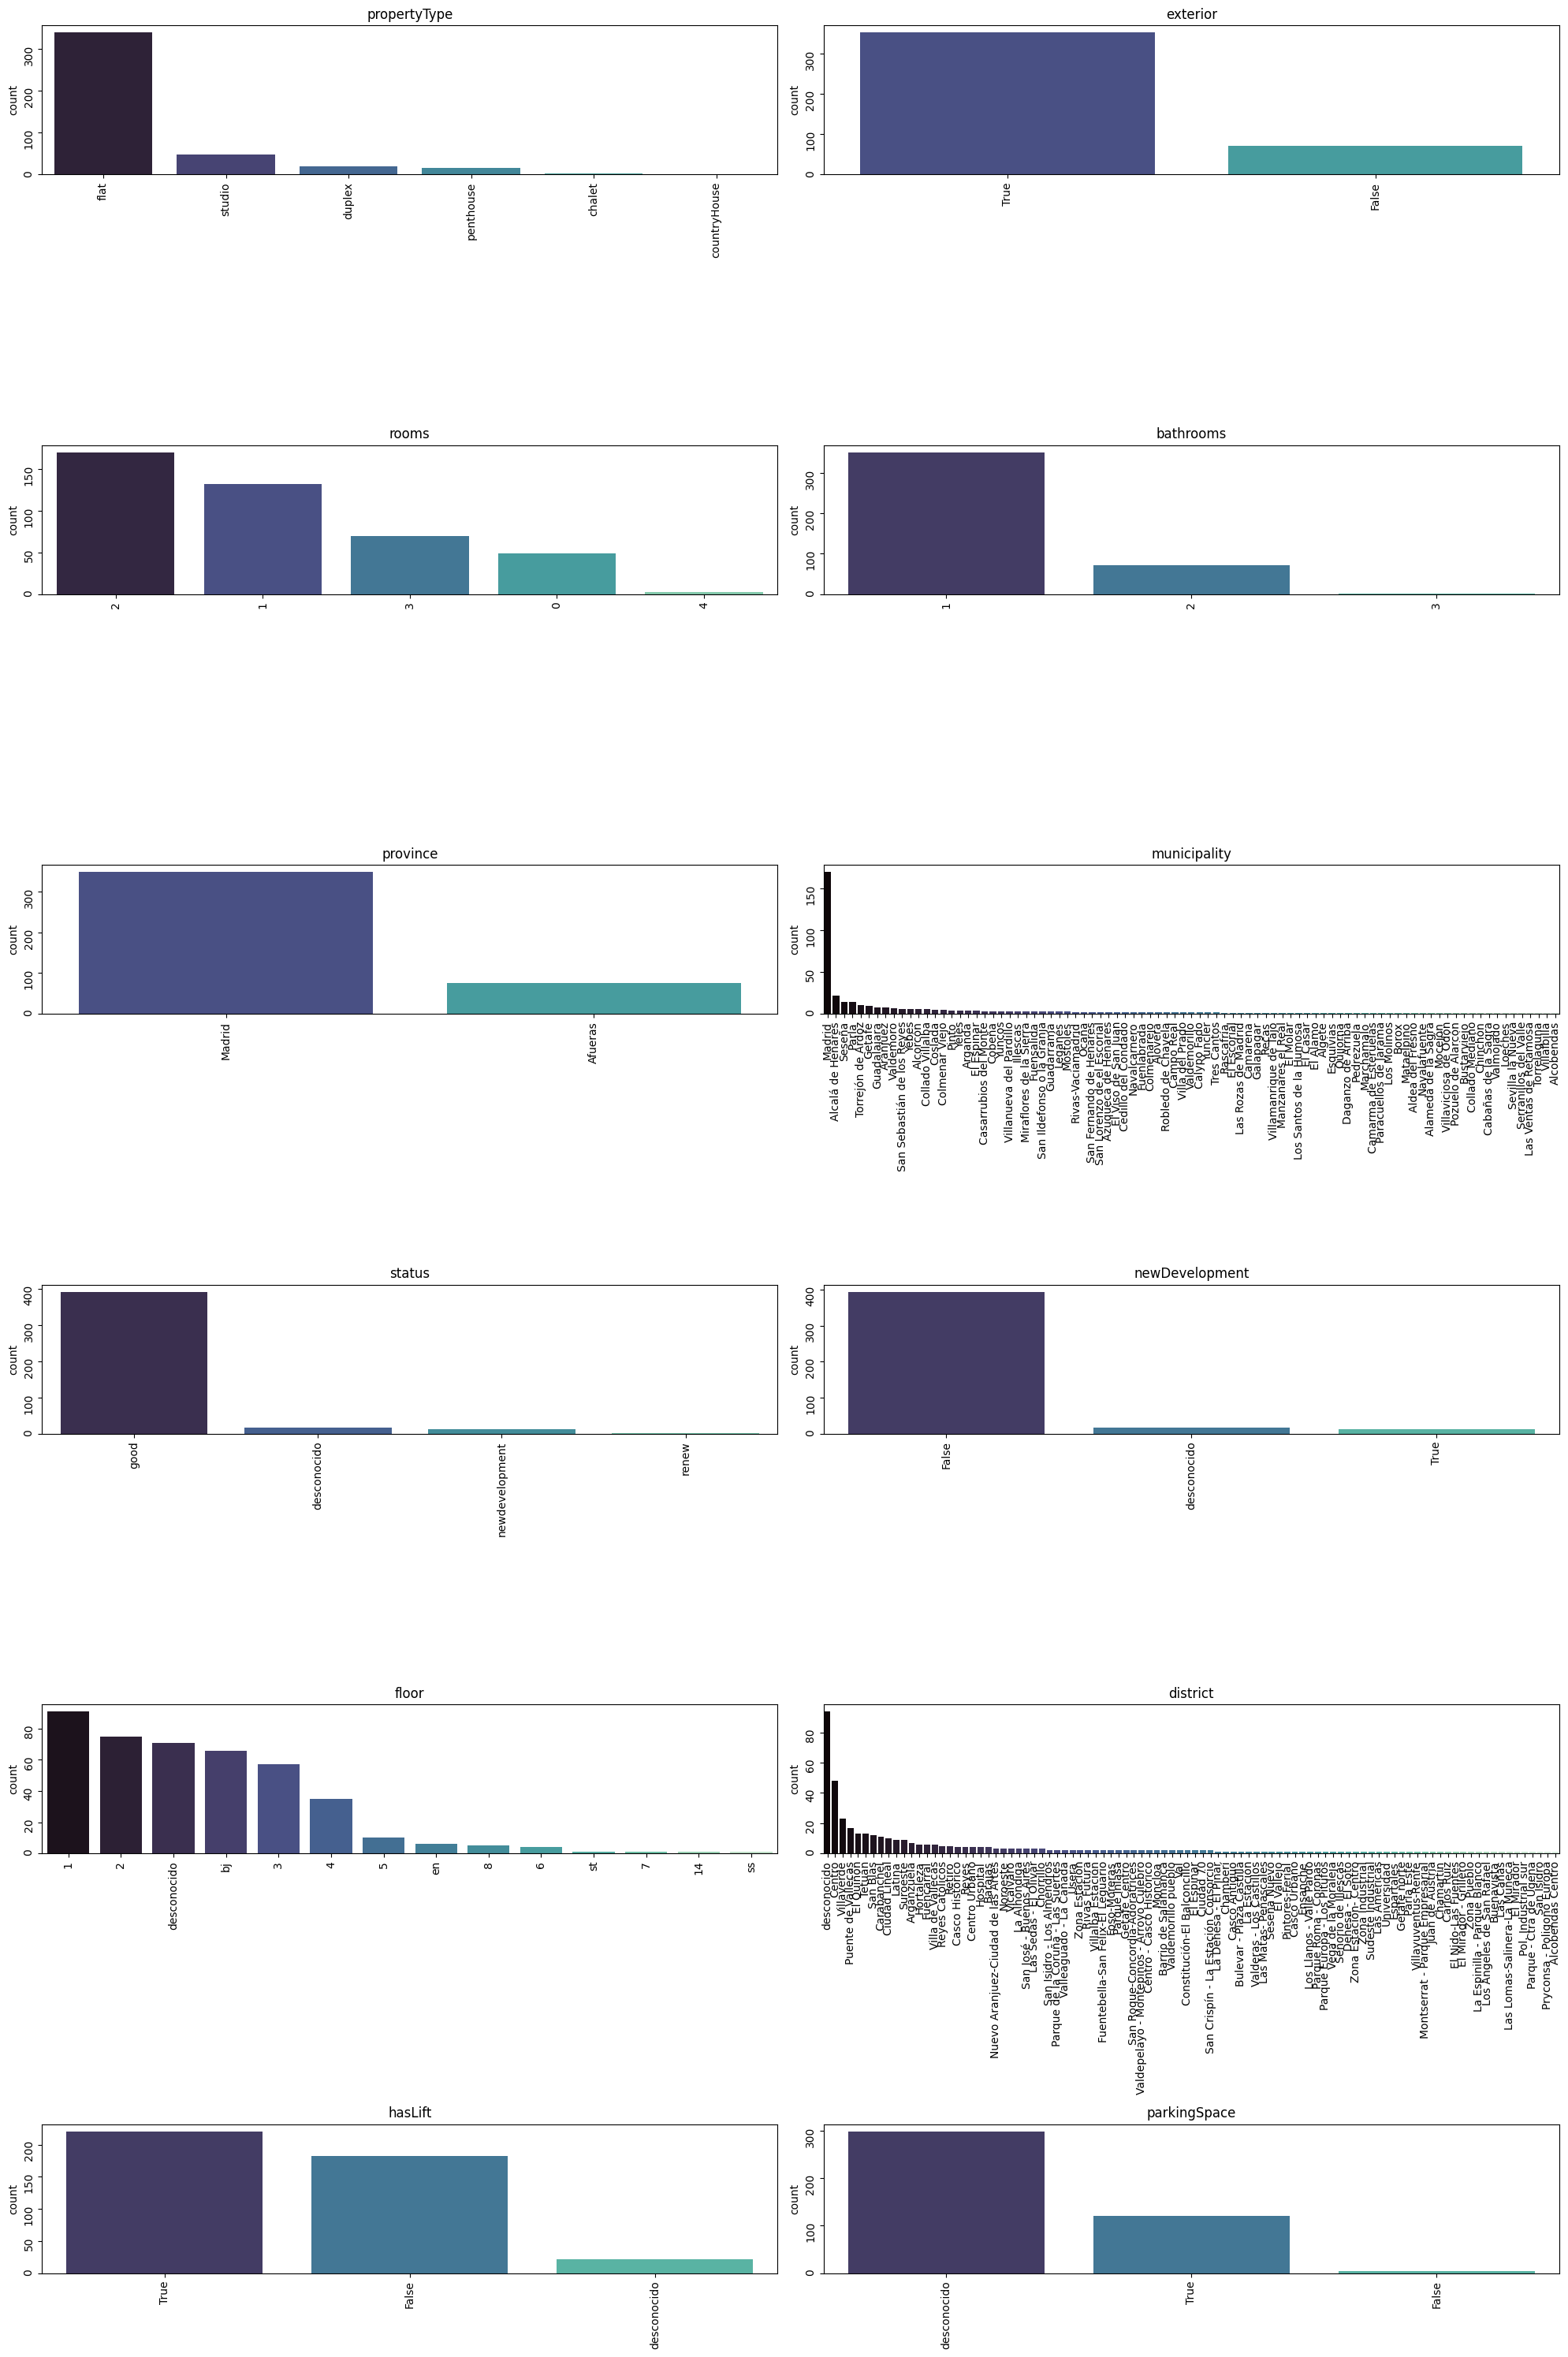

In [13]:
f.plot_categoricas(df_categoricas, (20,30))

Ahora vamos a visualizar la relación entre la dependiente y las categóricas 

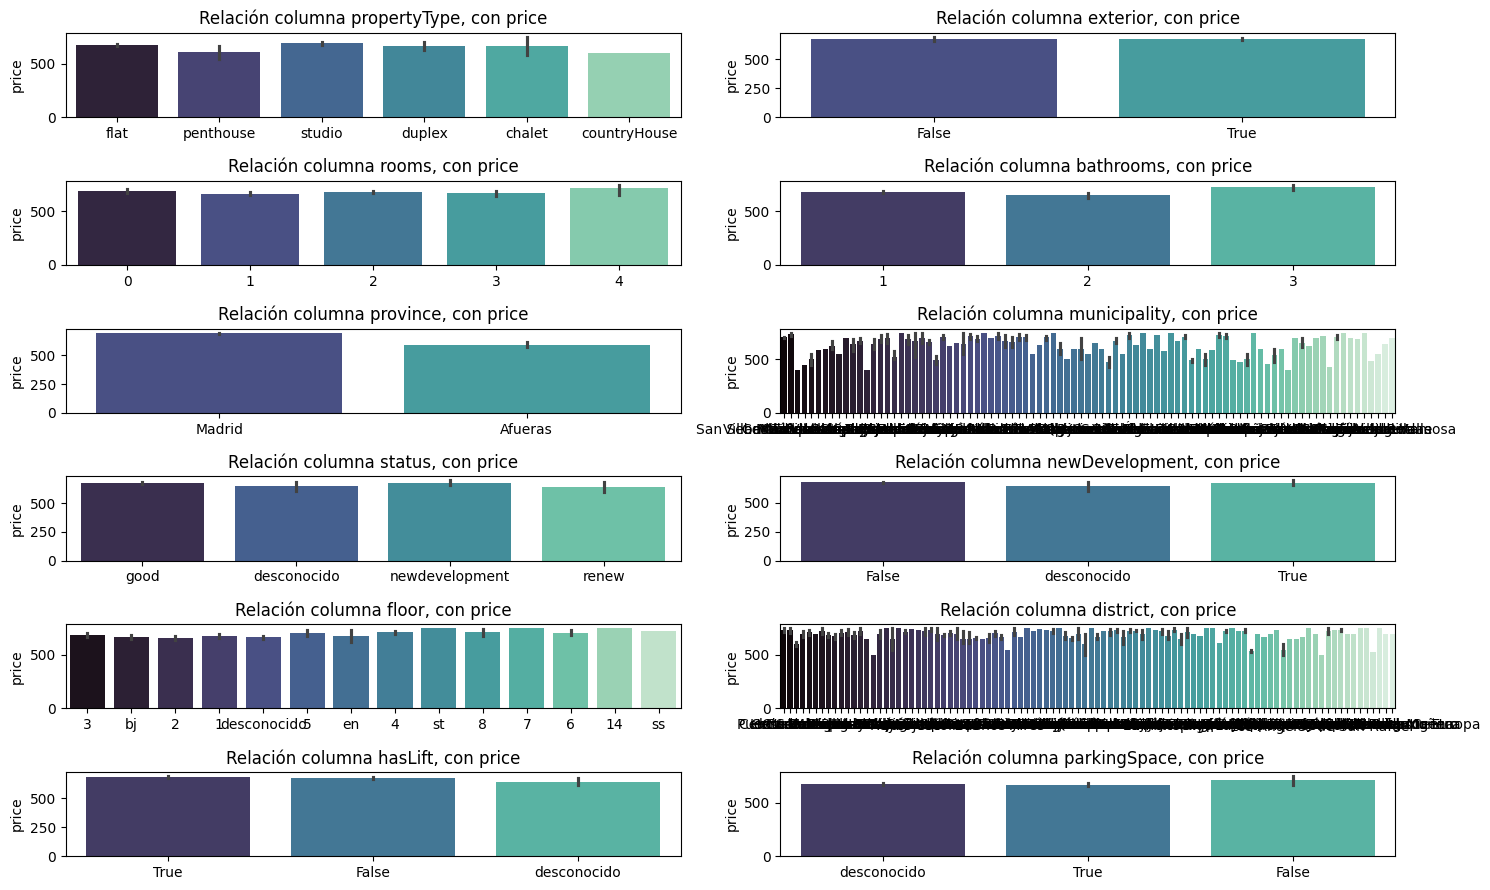

In [14]:
f.visualizar_categoricas(df_sinout_copy, "price", (15,9), "bar")

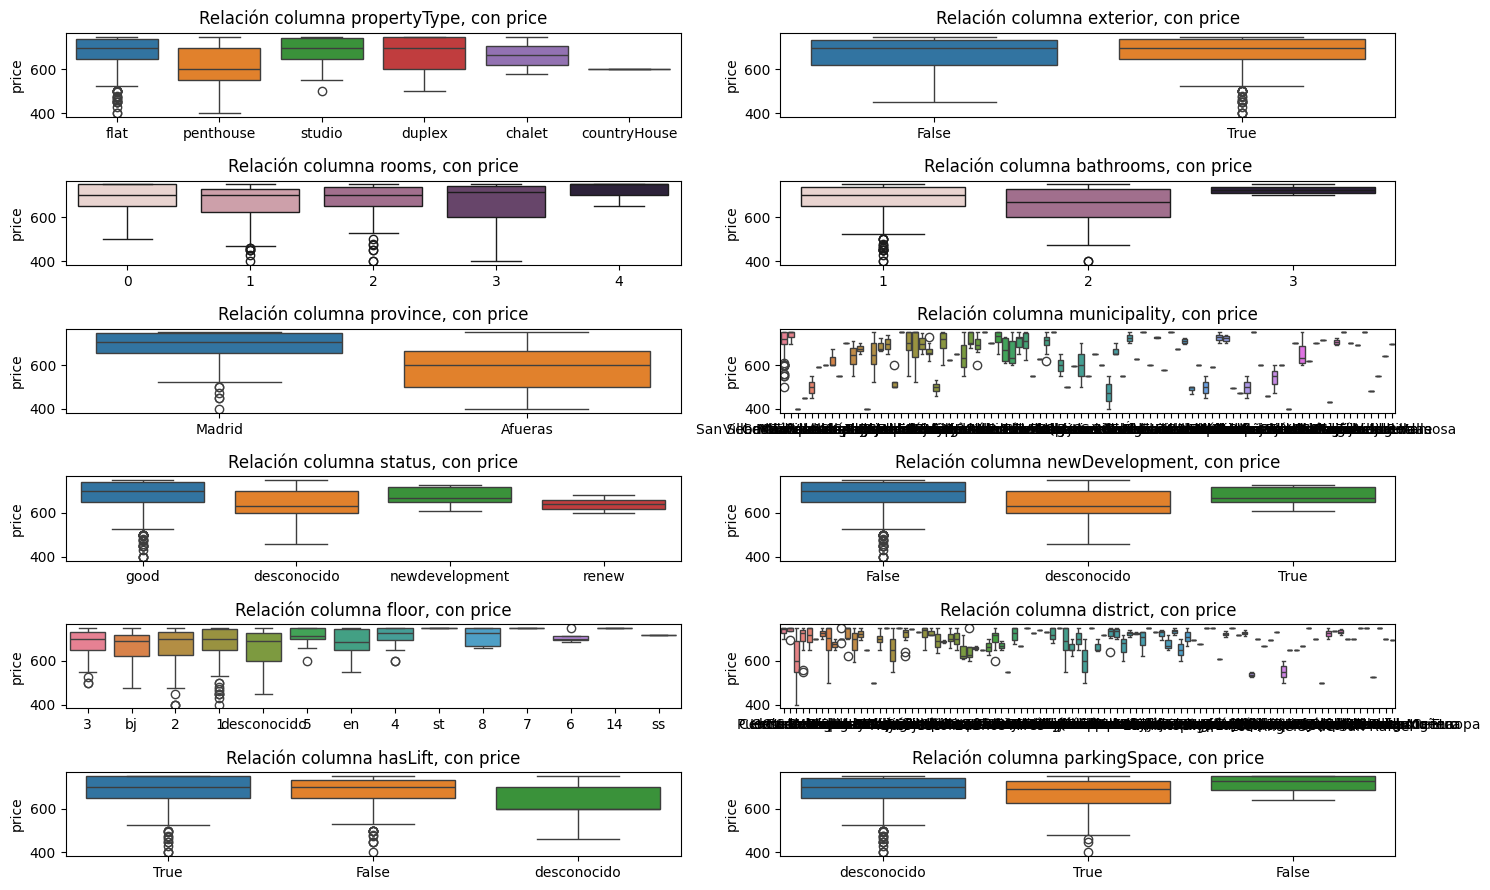

In [15]:
f.visualizar_categoricas(df_sinout_copy, "price", (15,9), "box")

Ahora debemos comprobar la normalidad y homocedasticidad para saber si son parametricas o no parametricas (Con el fin de más adelante poder evaluar si hay diferencias significativas)

Estamos probando primero con kruskal para en aquellas que solo tienen dos categoría comparar con Whitney

Tuve que convertir estas variables a str porque sino no las detectaba como categóricas

In [18]:
df_sinout_copy["exterior"]=df_sinout_copy["exterior"].astype(str)
df_sinout_copy["rooms"]=df_sinout_copy["rooms"].astype(str)
df_sinout_copy["bathrooms"]=df_sinout_copy["bathrooms"].astype(str)

In [19]:
# llamamos a la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
asunciones = f.Asunciones(dataframe = df_sinout_copy, columna_numerica= "price")
print("\n-------------\n")
lista_col_categ=df_sinout_copy.select_dtypes(include="O")

for categoria in lista_col_categ:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # llamamos la clase de test estadísticos para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = f.TestEstadisticos(df_sinout_copy, "price", categoria)
    test.run_all_tests()
    print("\n###########################\n")


-------------

Estamos analizando la variable PROPERTYTYPE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable propertyType las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['flat', 'penthouse', 'studio', 'duplex', 'chalet', 'countryHouse']

Realizando test de Kruskal...
Estadístico de prueba: 7.32663691544894
Valor p: 0.19745904092902525
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-65.00,0.98,-340.97,210.97,chalet-countryHouse
1,3.42,1.00,-164.09,170.93,chalet-duplex
2,12.18,1.00,-147.62,171.98,chalet-flat
3,-59.40,0.92,-229.02,110.22,chalet-penthouse
4,24.62,1.00,-137.99,187.24,chalet-studio
5,68.42,0.96,-162.76,299.61,countryHouse-duplex
6,77.18,0.92,-148.48,302.84,countryHouse-flat
7,5.60,1.00,-227.12,238.32,countryHouse-penthouse
8,89.62,0.87,-138.04,317.29,countryHouse-studio
9,8.76,1.00,-44.36,61.88,duplex-flat



###########################

Estamos analizando la variable EXTERIOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable exterior las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False']

Realizando test de Kruskal...
Estadístico de prueba: 0.0284872169855813
Valor p: 0.8659684585770435
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,1.61,0.88,-18.76,21.98,False-True



###########################

Estamos analizando la variable ROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable rooms las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '3', '0', '4']

Realizando test de Kruskal...
Estadístico de prueba: 3.9808403428147194
Valor p: 0.4086050373643634
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-23.96,0.37,-60.39,12.48,0-1
1,-11.24,0.91,-46.55,24.07,0-2
2,-22.11,0.57,-62.68,18.45,0-3
3,25.81,0.98,-103.72,155.34,0-4
4,12.72,0.64,-12.55,37.98,1-2
5,1.84,1.00,-30.36,34.04,1-3
6,49.77,0.82,-77.39,176.92,1-4
7,-10.87,0.87,-41.80,20.05,2-3
8,37.05,0.93,-89.79,163.89,2-4
9,47.92,0.84,-80.48,176.32,3-4



###########################

Estamos analizando la variable BATHROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable bathrooms las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '3']

Realizando test de Kruskal...
Estadístico de prueba: 6.916508730760369
Valor p: 0.031484674813933675
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-29.93,0.01,-54.08,-5.77,1-2
1,44.77,0.70,-86.85,176.40,1-3
2,74.70,0.38,-58.39,207.79,2-3



###########################

Estamos analizando la variable PROVINCE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable province las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Madrid', 'Afueras']

Realizando test de Kruskal...
Estadístico de prueba: 64.98357436295458
Valor p: 7.5524997372016745e-16
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,100.31,0.00,82.96,117.67,Afueras-Madrid



###########################

Estamos analizando la variable MUNICIPALITY
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable municipality las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Madrid', 'San Sebastián de los Reyes', 'Villamanrique de Tajo', 'Recas', 'Cedillo del Condado', 'Rascafría', 'Manzanares el Real', 'Miraflores de la Sierra', 'El Viso de San Juan', 'Galapagar', 'Arganda', 'San Lorenzo de el Escorial', 'Camarena', 'Aranjuez', 'Villanueva del Pardillo', 'Azuqueca de Henares', 'El Espinar', 'Las Rozas de Madrid', 'Guadalajara', 'Illescas', 'Navalcarnero', 'Seseña', 'Casarrubios del Monte', 'Alcalá de Henares', 'El Escorial', 'Calypo Fado', 'Leganés', 'Coslada', 'Torrejón de Ardoz', 'Marchamalo', 'Camarma de Esteruelas', 'Alcorcón', 'Pinto', 'Valdemoro', 'Collado Villalba', 'Getafe', 'Paracuellos de Jarama', 'El Molar', 'Parla', 'Tres Cantos', 'Yuncos', 'Esquivias', 'Quijo

,meandiff,p-adj,lower,upper,group_diff
0,105.09,1.00,-115.20,325.38,Alameda de la Sagra-Alcalá de Henares
1,95.00,1.00,-209.69,399.69,Alameda de la Sagra-Alcobendas
2,120.00,1.00,-112.71,352.71,Alameda de la Sagra-Alcorcón
3,75.00,1.00,-229.69,379.69,Alameda de la Sagra-Aldea del Fresno
4,150.00,1.00,-154.69,454.69,Alameda de la Sagra-Algete
...,...,...,...,...,...
3911,-103.33,0.99,-279.25,72.58,Yebes-Yuncler
3912,-53.33,1.00,-205.68,99.01,Yebes-Yuncos
3913,75.00,1.00,-111.58,261.58,Yeles-Yuncler
3914,125.00,0.67,-39.55,289.55,Yeles-Yuncos



###########################

Estamos analizando la variable STATUS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable status las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['good', 'desconocido', 'newdevelopment', 'renew']

Realizando test de Kruskal...
Estadístico de prueba: 5.9101857180754696
Valor p: 0.11606259214292115
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,31.34,0.39,-19.52,82.21,desconocido-good
1,30.78,0.72,-44.87,106.43,desconocido-newdevelopment
2,-5.53,1.00,-159.02,147.96,desconocido-renew
3,-0.56,1.00,-58.45,57.32,good-newdevelopment
4,-36.87,0.91,-182.43,108.68,good-renew
5,-36.31,0.93,-192.26,119.65,newdevelopment-renew



###########################

Estamos analizando la variable NEWDEVELOPMENT
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable newDevelopment las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['False', 'desconocido', 'True']

Realizando test de Kruskal...
Estadístico de prueba: 4.562518526428268
Valor p: 0.10215548504087855
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-0.38,1.00,-53.12,52.36,False-True
1,-31.16,0.25,-77.50,15.19,False-desconocido
2,-30.78,0.55,-99.71,38.16,True-desconocido



###########################

Estamos analizando la variable FLOOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable floor las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['3', 'bj', '2', '1', 'desconocido', '5', 'en', '4', 'st', '8', '7', '6', '14', 'ss']

Realizando test de Kruskal...
Estadístico de prueba: 21.968979478998808
Valor p: 0.055844284207190314
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,77.27,1.00,-190.87,345.42,1-14
1,-11.65,1.00,-53.24,29.95,1-2
2,11.71,1.00,-33.33,56.76,1-3
3,37.70,0.48,-15.34,90.75,1-4
4,36.27,0.98,-52.57,125.12,1-5
...,...,...,...,...,...
86,57.08,1.00,-211.47,325.64,desconocido-ss
87,87.08,1.00,-181.47,355.64,desconocido-st
88,40.83,1.00,-247.22,328.88,en-ss
89,70.83,1.00,-217.22,358.88,en-st



###########################

Estamos analizando la variable DISTRICT
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable district las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Hortaleza', 'Centro Urbano', 'desconocido', 'Puente de Vallecas', 'Ciudad Lineal', 'Casco Antiguo', 'Moncloa', 'Centro', 'Centro - Casco Histórico', 'Retiro', 'Arganzuela', 'Latina', 'Barrio de Salamanca', 'Bulevar - Plaza Castilla', 'La Estación', 'Barajas', 'Las Matas- Peñascales', 'San Roque-Concordia-Adoratrices', 'Chamberí', 'Villaverde', 'La Dehesa - El Pinar', 'Seseña Nuevo', 'Reyes Católicos', 'Chorrillo', 'Valdepelayo - Montepinos - Arroyo Culebro', 'Valleaguado - La Cañada', 'Suroeste', 'San Isidro - Los Almendros', 'San José - Buenos Aires', 'Hospital', 'Parque de la Coruña - Las Suertes', 'Valderas - Los Castillos', 'Getafe Centro', 'San Blas', 'Val', 'Casco Urbano', 'Casco Histórico', 'Los Llan

,meandiff,p-adj,lower,upper,group_diff
0,23.57,1.00,-296.63,343.77,Alcobendas Centro-Arganzuela
1,3.75,1.00,-331.13,338.63,Alcobendas Centro-Barajas
2,27.50,1.00,-339.34,394.34,Alcobendas Centro-Barrio de Salamanca
3,40.00,1.00,-383.59,463.59,Alcobendas Centro-Buenavista
4,-45.00,1.00,-468.59,378.59,Alcobendas Centro-Bulevar - Plaza Castilla
...,...,...,...,...,...
4555,-50.00,1.00,-473.59,373.59,Zona Estación- Centro-Zona Pueblo
4556,-148.41,1.00,-449.53,152.70,Zona Estación- Centro-desconocido
4557,-50.00,1.00,-473.59,373.59,Zona Industrial-Zona Pueblo
4558,-148.41,1.00,-449.53,152.70,Zona Industrial-desconocido



###########################

Estamos analizando la variable HASLIFT
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable hasLift las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False', 'desconocido']

Realizando test de Kruskal...
Estadístico de prueba: 5.43672997448314
Valor p: 0.06598254858875037
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,6.97,0.66,-11.72,25.65,False-True
1,-30.24,0.22,-73.27,12.78,False-desconocido
2,-37.21,0.10,-79.84,5.42,True-desconocido



###########################

Estamos analizando la variable PARKINGSPACE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable parkingSpace las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['desconocido', 'True', 'False']

Realizando test de Kruskal...
Estadístico de prueba: 3.8197247650233557
Valor p: 0.14810076644861545
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-41.41,0.56,-136.57,53.74,False-True
1,-32.27,0.70,-126.51,61.97,False-desconocido
2,9.14,0.54,-11.03,29.32,True-desconocido



###########################



Ahora con Mann-Whitney

In [20]:
# instanciamos la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
asunciones = f.Asunciones(dataframe = df_sinout_copy, columna_numerica= "price")
print("\n-------------\n")
lista_col_categ=df_sinout_copy.select_dtypes(include="O")

for categoria in lista_col_categ:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = f.TestEstadisticos(df_sinout_copy, "price", categoria)
    test.run_all_tests()
    print("\n###########################\n")


-------------

Estamos analizando la variable PROPERTYTYPE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable propertyType las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['flat', 'penthouse', 'studio', 'duplex', 'chalet', 'countryHouse']



Realizando test de Kruskal...
Estadístico de prueba: 7.32663691544894
Valor p: 0.19745904092902525
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-65.00,0.98,-340.97,210.97,chalet-countryHouse
1,3.42,1.00,-164.09,170.93,chalet-duplex
2,12.18,1.00,-147.62,171.98,chalet-flat
3,-59.40,0.92,-229.02,110.22,chalet-penthouse
4,24.62,1.00,-137.99,187.24,chalet-studio
5,68.42,0.96,-162.76,299.61,countryHouse-duplex
6,77.18,0.92,-148.48,302.84,countryHouse-flat
7,5.60,1.00,-227.12,238.32,countryHouse-penthouse
8,89.62,0.87,-138.04,317.29,countryHouse-studio
9,8.76,1.00,-44.36,61.88,duplex-flat



###########################

Estamos analizando la variable EXTERIOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable exterior las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False']

Realizando test de Mannwhitneyu...
Estadístico del Test de Mann-Whitney U: 12689.5
Valor p: 0.8663886155982016
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,1.61,0.88,-18.76,21.98,False-True



###########################

Estamos analizando la variable ROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable rooms las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '3', '0', '4']

Realizando test de Kruskal...
Estadístico de prueba: 3.9808403428147194
Valor p: 0.4086050373643634
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-23.96,0.37,-60.39,12.48,0-1
1,-11.24,0.91,-46.55,24.07,0-2
2,-22.11,0.57,-62.68,18.45,0-3
3,25.81,0.98,-103.72,155.34,0-4
4,12.72,0.64,-12.55,37.98,1-2
5,1.84,1.00,-30.36,34.04,1-3
6,49.77,0.82,-77.39,176.92,1-4
7,-10.87,0.87,-41.80,20.05,2-3
8,37.05,0.93,-89.79,163.89,2-4
9,47.92,0.84,-80.48,176.32,3-4



###########################

Estamos analizando la variable BATHROOMS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable bathrooms las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['1', '2', '3']

Realizando test de Kruskal...
Estadístico de prueba: 6.916508730760369
Valor p: 0.031484674813933675
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-29.93,0.01,-54.08,-5.77,1-2
1,44.77,0.70,-86.85,176.40,1-3
2,74.70,0.38,-58.39,207.79,2-3



###########################

Estamos analizando la variable PROVINCE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable province las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Madrid', 'Afueras']

Realizando test de Mannwhitneyu...
Estadístico del Test de Mann-Whitney U: 20976.0
Valor p: 7.584695941186992e-16
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,100.31,0.00,82.96,117.67,Afueras-Madrid



###########################

Estamos analizando la variable MUNICIPALITY
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable municipality las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Madrid', 'San Sebastián de los Reyes', 'Villamanrique de Tajo', 'Recas', 'Cedillo del Condado', 'Rascafría', 'Manzanares el Real', 'Miraflores de la Sierra', 'El Viso de San Juan', 'Galapagar', 'Arganda', 'San Lorenzo de el Escorial', 'Camarena', 'Aranjuez', 'Villanueva del Pardillo', 'Azuqueca de Henares', 'El Espinar', 'Las Rozas de Madrid', 'Guadalajara', 'Illescas', 'Navalcarnero', 'Seseña', 'Casarrubios del Monte', 'Alcalá de Henares', 'El Escorial', 'Calypo Fado', 'Leganés', 'Coslada', 'Torrejón de Ardoz', 'Marchamalo', 'Camarma de Esteruelas', 'Alcorcón', 'Pinto', 'Valdemoro', 'Collado Villalba', 'Getafe', 'Paracuellos de Jarama', 'El Molar', 'Parla', 'Tres Cantos', 'Yuncos', 'Esquivias', 'Quijo

,meandiff,p-adj,lower,upper,group_diff
0,105.09,1.00,-115.20,325.38,Alameda de la Sagra-Alcalá de Henares
1,95.00,1.00,-209.69,399.69,Alameda de la Sagra-Alcobendas
2,120.00,1.00,-112.71,352.71,Alameda de la Sagra-Alcorcón
3,75.00,1.00,-229.69,379.69,Alameda de la Sagra-Aldea del Fresno
4,150.00,1.00,-154.69,454.69,Alameda de la Sagra-Algete
...,...,...,...,...,...
3911,-103.33,0.99,-279.25,72.58,Yebes-Yuncler
3912,-53.33,1.00,-205.68,99.01,Yebes-Yuncos
3913,75.00,1.00,-111.58,261.58,Yeles-Yuncler
3914,125.00,0.67,-39.55,289.55,Yeles-Yuncos



###########################

Estamos analizando la variable STATUS
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable status las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['good', 'desconocido', 'newdevelopment', 'renew']

Realizando test de Kruskal...
Estadístico de prueba: 5.9101857180754696
Valor p: 0.11606259214292115
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,31.34,0.39,-19.52,82.21,desconocido-good
1,30.78,0.72,-44.87,106.43,desconocido-newdevelopment
2,-5.53,1.00,-159.02,147.96,desconocido-renew
3,-0.56,1.00,-58.45,57.32,good-newdevelopment
4,-36.87,0.91,-182.43,108.68,good-renew
5,-36.31,0.93,-192.26,119.65,newdevelopment-renew



###########################

Estamos analizando la variable NEWDEVELOPMENT
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable newDevelopment las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['False', 'desconocido', 'True']

Realizando test de Kruskal...
Estadístico de prueba: 4.562518526428268
Valor p: 0.10215548504087855
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-0.38,1.00,-53.12,52.36,False-True
1,-31.16,0.25,-77.50,15.19,False-desconocido
2,-30.78,0.55,-99.71,38.16,True-desconocido



###########################

Estamos analizando la variable FLOOR
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable floor las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['3', 'bj', '2', '1', 'desconocido', '5', 'en', '4', 'st', '8', '7', '6', '14', 'ss']

Realizando test de Kruskal...
Estadístico de prueba: 21.968979478998808
Valor p: 0.055844284207190314
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,77.27,1.00,-190.87,345.42,1-14
1,-11.65,1.00,-53.24,29.95,1-2
2,11.71,1.00,-33.33,56.76,1-3
3,37.70,0.48,-15.34,90.75,1-4
4,36.27,0.98,-52.57,125.12,1-5
...,...,...,...,...,...
86,57.08,1.00,-211.47,325.64,desconocido-ss
87,87.08,1.00,-181.47,355.64,desconocido-st
88,40.83,1.00,-247.22,328.88,en-ss
89,70.83,1.00,-217.22,358.88,en-st



###########################

Estamos analizando la variable DISTRICT
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable district las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Hortaleza', 'Centro Urbano', 'desconocido', 'Puente de Vallecas', 'Ciudad Lineal', 'Casco Antiguo', 'Moncloa', 'Centro', 'Centro - Casco Histórico', 'Retiro', 'Arganzuela', 'Latina', 'Barrio de Salamanca', 'Bulevar - Plaza Castilla', 'La Estación', 'Barajas', 'Las Matas- Peñascales', 'San Roque-Concordia-Adoratrices', 'Chamberí', 'Villaverde', 'La Dehesa - El Pinar', 'Seseña Nuevo', 'Reyes Católicos', 'Chorrillo', 'Valdepelayo - Montepinos - Arroyo Culebro', 'Valleaguado - La Cañada', 'Suroeste', 'San Isidro - Los Almendros', 'San José - Buenos Aires', 'Hospital', 'Parque de la Coruña - Las Suertes', 'Valderas - Los Castillos', 'Getafe Centro', 'San Blas', 'Val', 'Casco Urbano', 'Casco Histórico', 'Los Llan

,meandiff,p-adj,lower,upper,group_diff
0,23.57,1.00,-296.63,343.77,Alcobendas Centro-Arganzuela
1,3.75,1.00,-331.13,338.63,Alcobendas Centro-Barajas
2,27.50,1.00,-339.34,394.34,Alcobendas Centro-Barrio de Salamanca
3,40.00,1.00,-383.59,463.59,Alcobendas Centro-Buenavista
4,-45.00,1.00,-468.59,378.59,Alcobendas Centro-Bulevar - Plaza Castilla
...,...,...,...,...,...
4555,-50.00,1.00,-473.59,373.59,Zona Estación- Centro-Zona Pueblo
4556,-148.41,1.00,-449.53,152.70,Zona Estación- Centro-desconocido
4557,-50.00,1.00,-473.59,373.59,Zona Industrial-Zona Pueblo
4558,-148.41,1.00,-449.53,152.70,Zona Industrial-desconocido



###########################

Estamos analizando la variable HASLIFT
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable hasLift las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['True', 'False', 'desconocido']

Realizando test de Kruskal...
Estadístico de prueba: 5.43672997448314
Valor p: 0.06598254858875037
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,6.97,0.66,-11.72,25.65,False-True
1,-30.24,0.22,-73.27,12.78,False-desconocido
2,-37.21,0.10,-79.84,5.42,True-desconocido



###########################

Estamos analizando la variable PARKINGSPACE
Para la columna price, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable parkingSpace las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['desconocido', 'True', 'False']

Realizando test de Kruskal...
Estadístico de prueba: 3.8197247650233557
Valor p: 0.14810076644861545
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-41.41,0.56,-136.57,53.74,False-True
1,-32.27,0.70,-126.51,61.97,False-desconocido
2,9.14,0.54,-11.03,29.32,True-desconocido



###########################



Las columnas a comparar entre whitney y kruskal son:  
EXTERIOR  
- MAN: NO HAY DIFERENCIAS 
- KRUSKAL: NO HAY DIFERENCIAS  
  
PROVINCE
- MAN: HAY DIFERENCIAS 
- KRUSKAL: HAY DIFERENCIAS  
  
Aunque las conclusiones no cambien, es más correcto usar la opción de Mann-Whitney y Kruskal combinadas (2º opción).  



#### FIJANDONOS TANTO EN LAS VISUALIZACIONES COMO EN EL TEST DE TUKEY HEMOS OBTENIDO LAS SIGUIENTES CONCLUSIONES:  

**NO ORDENADAS:**
- PROPERTYTYPE
- EXTERIOR
- ROOMS
- STATUS
- NEWDEVELOPMENT
- FLOOR
- HASLIFT
- PARKINGSPACE   
  
 *- get- dummies (pandas)*  
 *- One-Hot Encoding (SKlearn) (es más efectivo)*  
 *Ambas te crean tantas columnas como categorias hay en la columna y hace que en esa solo valga 1 las que coincidan y 0 el resto*


**ORDENADAS:**  
- BATHROOMS (entre 1 y 2 baños)
- PROVINCE  (entre Madrid y afueras)
- MUNICIPALITY (hay)
- DISTRICT  (hay)
  

*lo de entre parentesis hace referencia a la cantidad de categorías que son diferentes en esa columna*  

*- Ordinal Encoding  (Los codifica en función de los pesos que le digamos)*
*- Label Encoding (Los codifica en orden alfabetico)*  
*- Target Encoding (Los codifica en funcion de las medias (osea en función de la relación con la variable dependiente))*  
*- Frequency Encoding (Los codifica en funcion de la frecuencia(en función del value_counts))*  



**Ahora pasamos al encodin de las que no tienen orden:**

In [21]:
df_sinout_copy.columns

Index(['price', 'propertyType', 'exterior', 'rooms', 'bathrooms', 'province',
       'municipality', 'status', 'newDevelopment', 'floor', 'district',
       'hasLift', 'parkingSpace', 'size_MinMax', 'distance_MinMax',
       'outliers_ifo_0.01_100', 'outliers_ifo_0.01_400',
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.01_2000',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_400',
       'outliers_ifo_0.05_1000', 'outliers_ifo_0.05_2000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000'],
      dtype='object')

In [22]:
diccionario_encoding = {"onehot": ["propertyType", "exterior", "rooms", "status", "newDevelopment", "floor", "hasLift", "parkingSpace"], 
                        "dummies": [], # no metemos ninguna
                        'ordinal' : { }, #no metemos ninguna
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ["bathrooms", "province", "municipality", "district"]  
                        }

In [25]:
# df_copy_cat=df_sinout_copy.select_dtypes("O")

In [26]:
# dfcop=df_sinout_copy.copy()

In [ ]:
encoding=f.Encoding(dataframe = df_sinout_copy , diccionario_encoding= diccionario_encoding, variable_respuesta= "price")
df_sinout_copy= encoding.one_hot_encoding()
df_sinout_copy.head()
#nos genera 40 columnas nuevas aproximadamente

,price,propertyType,exterior,rooms,bathrooms,province,municipality,status,newDevelopment,floor,district,hasLift,parkingSpace,size_MinMax,distance_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,newDevelopment_False,newDevelopment_True,newDevelopment_desconocido,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido
0,750.00,flat,True,1,1,Madrid,Madrid,good,False,3,Hortaleza,True,desconocido,0.31,0.11,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,750.00,flat,True,2,1,Madrid,San Sebastián de los Reyes,good,False,bj,Centro Urbano,False,desconocido,0.39,0.27,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,400.00,penthouse,True,2,2,Madrid,Villamanrique de Tajo,good,False,2,desconocido,False,desconocido,0.36,0.92,1.00,1.00,1.00,1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
3,450.00,flat,False,2,1,Afueras,Recas,good,False,2,desconocido,True,True,0.53,0.79,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
4,450.00,flat,True,2,1,Afueras,Cedillo del Condado,good,False,1,desconocido,False,desconocido,0.31,0.64,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [29]:
df_sinout_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       424 non-null    float64
 1   propertyType                424 non-null    object 
 2   exterior                    424 non-null    object 
 3   rooms                       424 non-null    object 
 4   bathrooms                   424 non-null    object 
 5   province                    424 non-null    object 
 6   municipality                424 non-null    object 
 7   status                      424 non-null    object 
 8   newDevelopment              424 non-null    object 
 9   floor                       424 non-null    object 
 10  district                    424 non-null    object 
 11  hasLift                     424 non-null    object 
 12  parkingSpace                424 non-null    object 
 13  size_MinMax                 424 non

Aqui ya está codificada la de abtest en abtest_test vamos a por el resto

In [30]:
encoder_target= TargetEncoder(cols=["bathrooms", "province", "municipality", "district"])
encoded= encoder_target.fit_transform(df_sinout_copy , df_sinout_copy[["price"]])
lista_eliminar=["propertyType", "exterior", "rooms", "status", "newDevelopment", "floor", "hasLift", "parkingSpace"]
encoded.drop(columns=lista_eliminar, inplace=True)


In [33]:
encoded.head(2)

,price,bathrooms,province,municipality,district,size_MinMax,distance_MinMax,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,newDevelopment_False,newDevelopment_True,newDevelopment_desconocido,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido
0,750.00,680.23,693.41,705.59,687.21,0.31,0.11,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,750.00,680.23,693.41,687.37,685.64,0.39,0.27,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [31]:
encoded.columns

Index(['price', 'bathrooms', 'province', 'municipality', 'district',
       'size_MinMax', 'distance_MinMax', 'outliers_ifo_0.01_100',
       'outliers_ifo_0.01_400', 'outliers_ifo_0.01_1000',
       'outliers_ifo_0.01_2000', 'outliers_ifo_0.05_100',
       'outliers_ifo_0.05_400', 'outliers_ifo_0.05_1000',
       'outliers_ifo_0.05_2000', 'outliers_ifo_0.1_100',
       'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000', 'propertyType_chalet',
       'propertyType_countryHouse', 'propertyType_duplex', 'propertyType_flat',
       'propertyType_penthouse', 'propertyType_studio', 'exterior_False',
       'exterior_True', 'rooms_0', 'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4',
       'status_desconocido', 'status_good', 'status_newdevelopment',
       'status_renew', 'newDevelopment_False', 'newDevelopment_True',
       'newDevelopment_desconocido', 'floor_1', 'floor_14', 'floor_2',
       'floor_3', 'floor_4', 'floor_5', 'floor_6', 'floor_7', 'floor_8',
       

In [34]:
df_final_encoded=encoded[['price', 'bathrooms', 'province', 'municipality', 'district',
       'size_MinMax', 'distance_MinMax', 'propertyType_chalet',
       'propertyType_countryHouse', 'propertyType_duplex', 'propertyType_flat',
       'propertyType_penthouse', 'propertyType_studio', 'exterior_False',
       'exterior_True', 'rooms_0', 'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4',
       'status_desconocido', 'status_good', 'status_newdevelopment',
       'status_renew', 'newDevelopment_False', 'newDevelopment_True',
       'newDevelopment_desconocido', 'floor_1', 'floor_14', 'floor_2',
       'floor_3', 'floor_4', 'floor_5', 'floor_6', 'floor_7', 'floor_8',
       'floor_bj', 'floor_desconocido', 'floor_en', 'floor_ss', 'floor_st',
       'hasLift_False', 'hasLift_True', 'hasLift_desconocido',
       'parkingSpace_False', 'parkingSpace_True', 'parkingSpace_desconocido']]

TENGO QUE REVISAR PORQUE ME HA GENERADO NAN EN MONTCREATED

In [35]:
df_final_encoded.head()

,price,bathrooms,province,municipality,district,size_MinMax,distance_MinMax,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,newDevelopment_False,newDevelopment_True,newDevelopment_desconocido,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido
0,750.00,680.23,693.41,705.59,687.21,0.31,0.11,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,750.00,680.23,693.41,687.37,685.64,0.39,0.27,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,400.00,650.45,693.41,639.59,601.63,0.36,0.92,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
3,450.00,680.23,593.40,646.09,601.63,0.53,0.79,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
4,450.00,680.23,593.40,650.54,601.63,0.31,0.64,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [38]:
df_final_encoded.to_csv("../../datos/datos1/datos_nulos_minmax_encoded.csv")